### Try-it 8.1: The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
cali = pd.read_csv('data/housing.csv')

In [4]:
cali.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
cali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
print(f'Missing data {((20640 - 20433)*100) / 20640}%')

Missing data 1.002906976744186%


### Data analysis

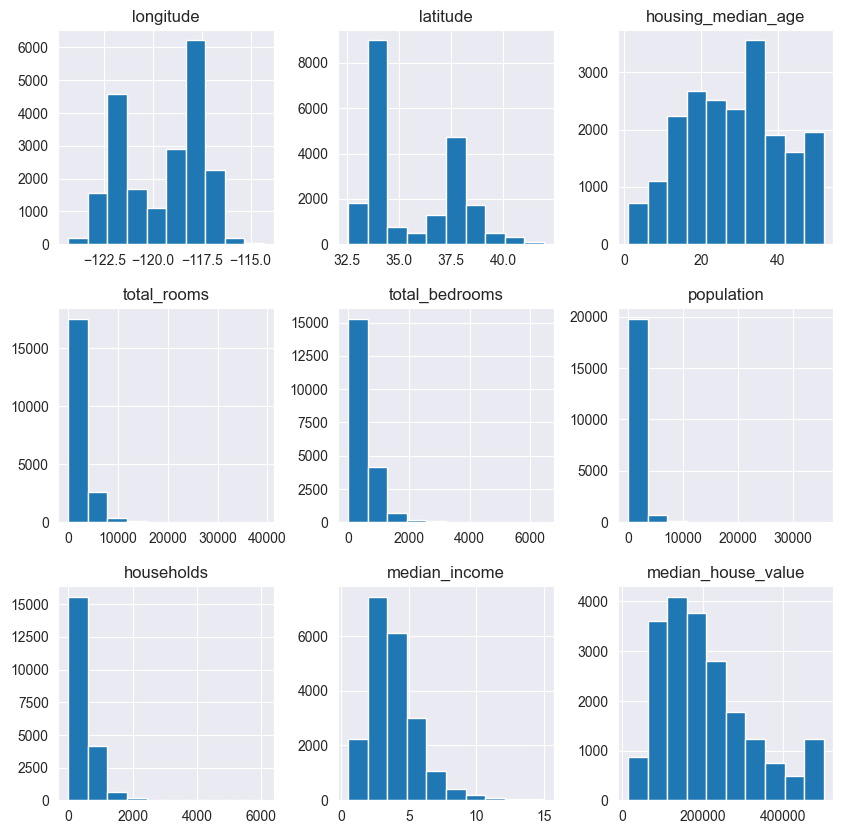

In [7]:
cali.hist(bins=10, figsize=(10,10))
plt.show()

In [8]:
#as the sample is small fill NaN values with median of total bedrooms
median = cali["total_bedrooms"].median()
cali["total_bedrooms"].fillna(median, inplace = True)

In [9]:
cali['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### The OrdinalEncoder will be used to encode features that do not need to be binarized due to an underlying order

In [10]:
#ohe = OneHotEncoder(sparse = False, drop='if_binary')
#cali['ocean_proximity'] = ohe.fit_transform(cali[['ocean_proximity']])

In [11]:
ordinal_encoder = OrdinalEncoder()

cali['ocean_proximity'] = ordinal_encoder.fit_transform(cali[['ocean_proximity']])

In [12]:
cali[['ocean_proximity']].value_counts().reset_index()['ocean_proximity'].values

array([0., 1., 4., 3., 2.])

### Transforming the targets before learning a model

In [13]:
X = cali.drop('median_house_value', axis = 1)
y = cali['median_house_value']

In [14]:
X.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  ocean_proximity  
0       322.0       126.0         8.3252              3.0  
1      2401.0      1138.0         8.3014              3.0  
2       496.0       177.0         7.2574              3.0  
3       558.0       219.0         5.6431              3.0  
4       565.0       259.0         3.8462              3.0

### A QuantileTransformer is used to normalize the target distribution before applying a RidgeCV (LinearRegression) model.

In [15]:
# Target transformation
y_trans = quantile_transform(y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True).squeeze()

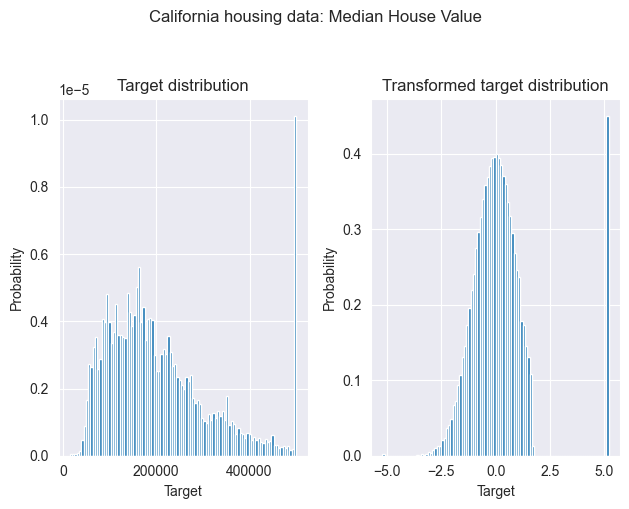

In [16]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("California housing data: Median House Value", y=1.05)
plt.tight_layout()

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

### Permutation feature importance
The permutation_importance function calculates the feature importance of estimators for a given dataset.

In [18]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1e-2).fit(X_train, y_train)
model.score(X_val, y_val)

0.6308586418762065

In [19]:
r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{cali.columns[i]:<8} {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")

latitude 1.246 +/- 0.016
longitude 1.105 +/- 0.019
median_income 0.874 +/- 0.012
total_bedrooms 0.365 +/- 0.007
population 0.255 +/- 0.008
total_rooms 0.049 +/- 0.002
housing_median_age 0.032 +/- 0.001
households 0.031 +/- 0.002


<Figure size 1000x1000 with 0 Axes>

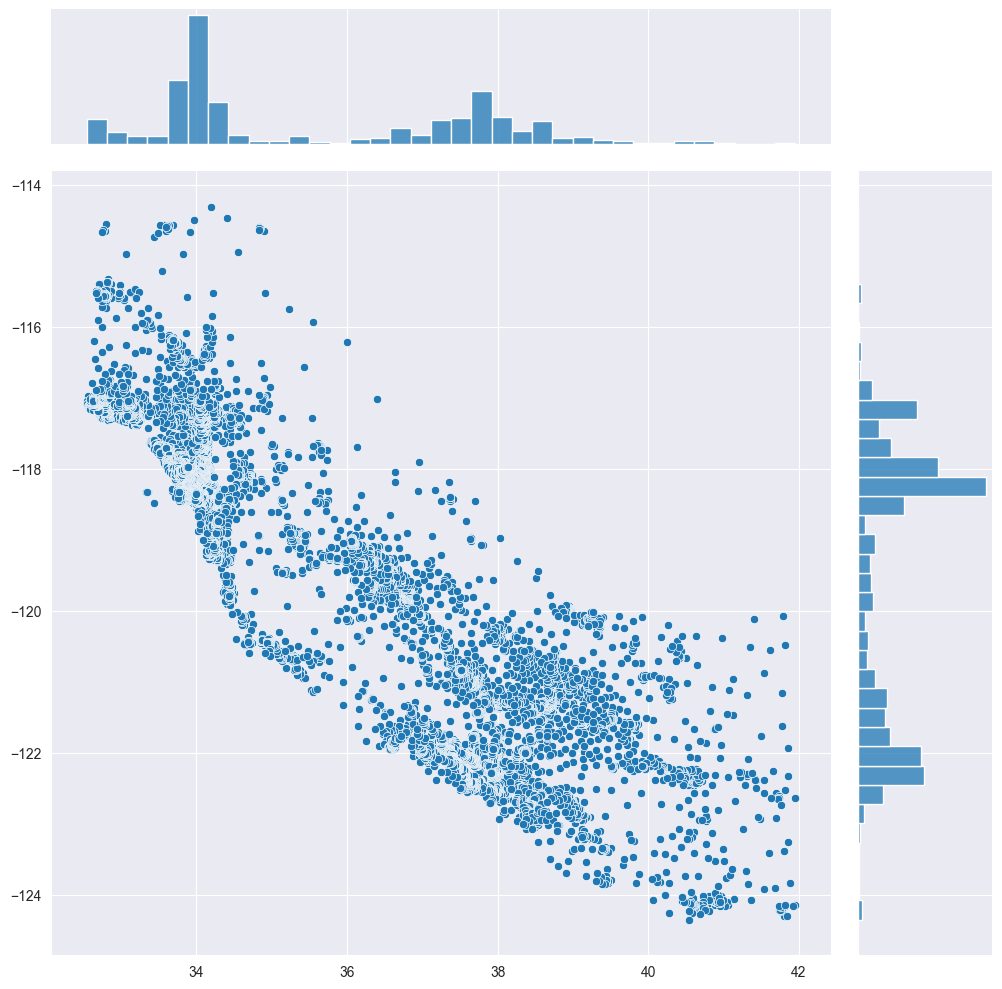

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [20]:
plt.figure(figsize=(10,10))
sns.jointplot(x=cali.latitude.values, y=cali.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
# plt1 = plt()
sns.despine

In [21]:
fig = px.scatter_mapbox(cali, #our data set
                        lat="latitude", lon="longitude", #location
                        color="median_house_value", #select a column for ranking
                        hover_name="median_house_value",
                        hover_data=["total_bedrooms", "total_rooms"],
                        color_discrete_sequence=["green"],
                        size_max=30,
                        zoom=5,
                        width=800, height=1200, #map size
                        title =  'Interactive Map of California area, check location')
#style of map
fig.update_layout(mapbox_style="open-street-map")
fig.show(config={'scrollZoom': False})

In [22]:
train_mses = []
test_mses = []
#for degree in 1 - 5
for i in range(1, 8):
    #create pipeline with PolynomialFeatures degree i
    poly_ordinal_oe = make_column_transformer((PolynomialFeatures(degree = i), make_column_selector(dtype_include=np.number)),
                                               (OrdinalEncoder(), ['ocean_proximity']))
    pipe = Pipeline([('transformer', poly_ordinal_oe), ('linreg', LinearRegression())])

    #fit on train
    pipe.fit(X_train, y_train)

    #predict on train and test
    p1 = pipe.predict(X_train)
    p2 = pipe.predict(X_val)

    #create MSEs for train and test sets
    train_mses.append(mean_squared_error(y_train, p1))
    test_mses.append(mean_squared_error(y_val, p2))

# Answer check
print(train_mses)
print(test_mses)
pipe

[4836678755.326479, 3931663071.3749943, 3231437002.7679424, 3127678444.7271495, 2752250067.3324676, 4701870907.84244, 6165977831.029108]
[4919147786.375661, 4371574156.191872, 15134957461.288725, 2885721300313.6025, 647187376215753.1, 4.307701094145797e+16, 1.9212474598188483e+20]


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=7),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C07613E980>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('linreg', LinearRegression())])

In [23]:
best_complexity = train_mses.index(min(train_mses)) + 1
best_mse = min(train_mses)

# Answer check
print(f'The best degree polynomial model is:  {best_complexity}')
print(f'The smallest mean squared error on the test data is : {best_mse: .2f}')

The best degree polynomial model is:  5
The smallest mean squared error on the test data is :  2752250067.33


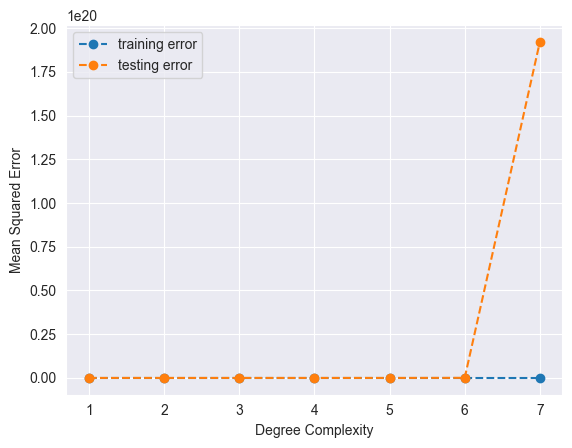

In [24]:
plt.plot(range(1, 8), train_mses, '--o', label = 'training error')
plt.plot(range(1, 8), test_mses, '--o', label = 'testing error')
plt.xticks(range(1, 8), range(1, 8))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

Text(0.5, 1.05, 'California housing data: Median House Value')

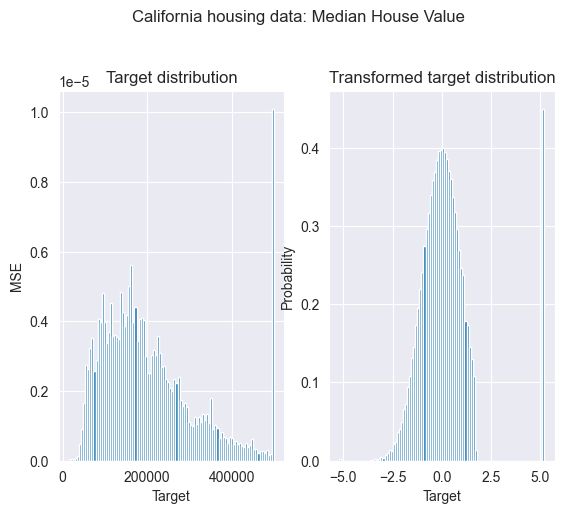

In [25]:
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_ylabel("MSE")
ax0.set_xlabel("Target")
ax0.set_title("Target distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.set_title("Transformed target distribution")

f.suptitle("California housing data: Median House Value", y=1.05)

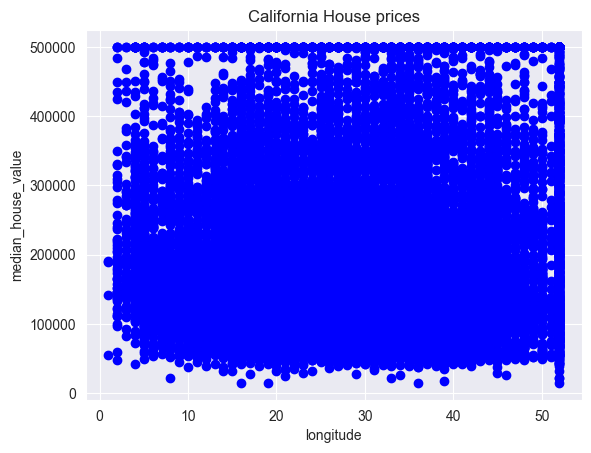

In [26]:
X2 = X[['housing_median_age']].values
y2 = y.values
X2_grid = np.arange(min(X2),max(X2),0.1)
X2_grid = X2_grid.reshape(len(X2_grid),1)

plt.scatter(X2, y2, color='blue')
#plt.plot(X2_grid, pipe.named_steps['linreg'].predict(pipe.named_steps['transformer'].fit_transform(X2_grid)),color='red')

plt.title("California House prices")
plt.xlabel('longitude')
plt.ylabel('median_house_value')
plt.show()